In [2]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time

# Directory Variables
base_dir = "../dataset"

# Q1. Does the inclusion of altitude information help the linear model perform better?

In [40]:
# Load the dataset
df_metadata = pd.read_excel(f"{base_dir}/FilledDataset2012.xlsx", sheet_name="Header")
df_data_original = pd.read_csv(f"{base_dir}/dataset.csv")

# make sure there is no NaN value
assert df_data_original.isnull().values.any() == False
print(f"There are {df_data_original.shape[0]} samples.")
print(
    "Each sample is associated with lat and lon coordinates.\n" + 
    "Use only the closest observation to represent each field, from 16 different NetCDF files.", )

There are 865561 samples.
Each sample is associated with lat and lon coordinates.
Use only the closest observation to represent each field, from 16 different NetCDF files.


In [80]:
df_combined = df_data_original.merge(right=df_metadata[["SKN", "ElevFT"]], left_on="skn", right_on="SKN")
df_clean = (
    df_combined.drop(
        labels=["lat", "lon", "year", "month", "SKN", "skn", "Lon_DD_updated"],
        axis=1
    ).rename(
        columns={"Lat_DD": "lat", "Lon_DD": "lon", "ElevFT": "elev"}
    )
)

In [93]:
mse_default = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in", "elev"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_default.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [94]:
mse_w_elev = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_w_elev.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [95]:
np.mean(mse_default), np.mean(mse_w_elev), np.std(mse_default), np.std(mse_w_elev)

(32.628002080285775,
 32.46782561580218,
 0.37201676642057857,
 0.3547847450535934)

<BarContainer object of 2 artists>

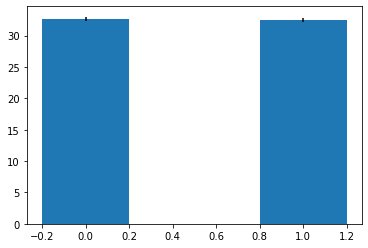

In [102]:
fig, ax = plt.subplots()
ax.bar(
    x=np.arange(2),
    height=[np.mean(mse_default), np.mean(mse_w_elev)],
    yerr=[np.std(mse_default), np.std(mse_w_elev)],
    width=0.4,
)

In [104]:
random_forest = RandomForestRegressor(n_jobs=-1, verbose=True)
random_forest.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, random_forest.predict(Xtest))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


6.3678634822428

In [106]:
xgb = XGBRegressor()
xgb.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, xgb.predict(Xtest))

9.984985208025531

# Q2. How does the performance change if we smooth out the observation of reanalysis data?

In [107]:
df_data_original

,skn,year,month,data_in,Lat_DD,Lon_DD,Lon_DD_updated,lat,lon,air,...,pottmp.1,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp
0,1.00,1948,1,3.200000,18.916176,-155.674994,204.325006,20.0,205.0,295.39603,...,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
1,2.00,1948,1,5.950000,19.108660,-155.825545,204.174455,20.0,205.0,295.39603,...,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
2,2.20,1948,1,11.500000,19.164740,-155.682280,204.317720,20.0,205.0,295.39603,...,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
3,2.25,1948,1,5.515941,19.160603,-155.822488,204.177512,20.0,205.0,295.39603,...,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
4,2.26,1948,1,4.310617,19.225323,-155.778876,204.221124,20.0,205.0,295.39603,...,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865556,1115.00,2009,11,39.366142,22.191765,-159.555534,200.444466,22.5,200.0,297.98657,...,-3.891937,31.408670,-15.272953,-87.770700,-2.358120,-20.720667,2.741999,10.625999,26.348024,1016.6897
865557,1115.10,2009,11,17.740000,22.195900,-159.556400,200.443600,22.5,200.0,297.98657,...,-3.891937,31.408670,-15.272953,-87.770700,-2.358120,-20.720667,2.741999,10.625999,26.348024,1016.6897
865558,1131.70,2009,11,37.530000,22.179583,-159.466389,200.533611,22.5,200.0,297.98657,...,-3.891937,31.408670,-15.272953,-87.770700,-2.358120,-20.720667,2.741999,10.625999,26.348024,1016.6897
865559,1134.00,2009,11,20.040000,22.211941,-159.407202,200.592798,22.5,200.0,297.98657,...,-3.891937,31.408670,-15.272953,-87.770700,-2.358120,-20.720667,2.741999,10.625999,26.348024,1016.6897


In [ ]:
# include altitude information and compare models
# Increase the resolution, and choose the closest grid cell
# 